# [E3]3rd_project_Cat_sticker

python opencv를 사용하여 나만의 카메라앱을 만들어보자
원본 이미지를 불러와서 detector_hog를 통해 얼굴 이미지를 검출한 후 
얼굴 이미지의 키값을 찾아내자 (키값 : 얼굴의 눈코입 각 포인트 점)
이후 얼굴의 키값을 통해 스티커를 이미지에 맞게 가공하여 붙인다.

처음 이미지를 불러와 resize를 하는데 사이즈가 크면 속도가 느려지는 현상이 있고
이미지를 줄일때 고정된 값으로 줄이게 되면 사진이 일그러져 얼굴을 검출하는데 어려움이 있다.
하여 비율값으로 resize를 하도록 변경하였고 width, height 각각 1/2씩 줄이도록 하였다.

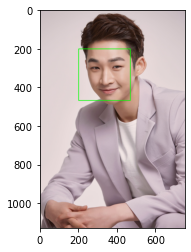

In [33]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import dlib

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image_1.jpg'
#my_image_path_1 = os.getenv('HOME')+'/aiffel/camera_sticker/images/image_1.jpg'
#my_image_path_2 = os.getenv('HOME')+'/aiffel/camera_sticker/images/image_2.jpg'
#my_image_path_3 = os.getenv('HOME')+'/aiffel/camera_sticker/images/image_3.jpg'


img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, dsize=(0, 0), fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR)    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

detector_hog = dlib.get_frontal_face_detector() 
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

고양이 수염을 붙일때 기준점을 33 포인트로 잡도록 하였다.
그리고 스티커의 위치 기준이 되는 refine_x, y값은 사진의 좌상단 좌표가 landmark 33포인트와 일치하도록 설정하였다.

In [34]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33]) # nose center index : 30
    x = landmark[33][0]
    y = landmark[33][1]  # - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))
    
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
refined_x = x - w // 2  # left
refined_y = y - h //2   # center

(343, 394)
(x,y) : (343,394)
(w,h) : (269,269)


스티커가 사진 밖으로 나가게 되는 경우는 refine의 값이 음수가 되는 경우이며, 
이 경우에만 스티커를 crop할 수 있도록 조건문 if를 추가하였다. 

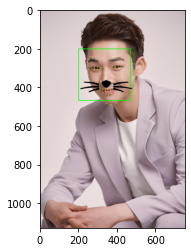

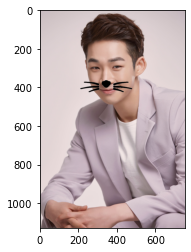

In [35]:
if refined_y<0:
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0
    
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 결론
여러 사진을 테스트 하면서 사진의 비율과 밝기, 명암 등 왠만한 모든 경우가 두 얼굴 탐색에 영향을 미쳤다
조금만 어긋나면 얼굴 탐색이 안되는 경우가 허다하며
사진이 멀어지게 되면 얼굴의 키포인트를 잡는 간격이 줄어들고 반대로 사진이 가까워지면 간격이 멀어지게 되므로 
스티커를 합성하는데에도 오차가 발생할 수 밖에 없었다.
결론은 적당한거리의 정면 사진을 잘 갖고 오는것이며 이를 일정한 비율로 사진을 줄여 성능을 높이는것도 중요하다.
스티커가 사진범위 밖으로 나가는 경우에 대해 나름 추가하기는 했지만 
나만의 온전한 카메라 앱을 갖기 위해서는 얼굴 인식에 대한 성능이 보장되어야 하며 이를 머신러닝 모델이 아닌
딥러닝 모델로 바꿔서 하게 되면 정말 수월하지 않을까 .. 생각된다. 